In [14]:
# 0
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("news_aggregator/newsCorpora.csv", sep="\t", names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])
df = df.loc[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]), ["TITLE", "CATEGORY"]]
train, val_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
val, test = train_test_split(val_test, test_size=0.5, shuffle=True, random_state=42)
train.to_csv('train.txt', sep='\t', index=False)
val.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

In [61]:
# 1
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def preprocessing(text):
    text = text.lower()
    #text = re.sub("[0-9]+", "0", text)
    return text

df = pd.read_csv("news_aggregator/newsCorpora.csv", sep="\t", names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])
df = df.loc[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]), ["TITLE"]]
df["TITLE"] = df["TITLE"].map(lambda x: preprocessing(x))

vectorizer = TfidfVectorizer(min_df=10)
features = vectorizer.fit_transform(df["TITLE"])
features = pd.DataFrame(features.toarray(), columns=vectorizer.get_feature_names())

train, val_test = train_test_split(features, test_size=0.2, shuffle=True, random_state=42)
val, test = train_test_split(val_test, test_size=0.5, shuffle=True, random_state=42)

train.to_csv('train.feature.txt', sep='\t', index=False)
val.to_csv('valid.feature.txt', sep='\t', index=False)
test.to_csv('test.feature.txt', sep='\t', index=False)

In [65]:
# 2
from sklearn.linear_model import LogisticRegression

x = pd.read_csv("train.feature.txt", sep="\t")
y = pd.read_csv("train.txt", sep="\t")["CATEGORY"]
model = LogisticRegression(random_state=42, max_iter=300)
model.fit(x, y)

LogisticRegression(max_iter=300, random_state=42)

In [70]:
# 3
def calc_score(model, x):
    pred = model.predict(x)
    prob = model.predict_proba(x)
    return pred, prob

x = pd.read_csv("train.feature.txt", sep="\t")
print(calc_score(model, x))

x = pd.read_csv("test.feature.txt", sep="\t")
print(calc_score(model, x))

(array(['b', 'e', 'e', ..., 'e', 'b', 'b'], dtype=object), array([[0.88331068, 0.08555597, 0.01275294, 0.01838041],
       [0.18259856, 0.39673751, 0.3260791 , 0.09458484],
       [0.09725359, 0.76896979, 0.07603702, 0.0577396 ],
       ...,
       [0.04219166, 0.85768439, 0.07723417, 0.02288977],
       [0.93293462, 0.03788706, 0.01822924, 0.01094908],
       [0.92495641, 0.0501749 , 0.01203027, 0.01283842]]))
(array(['b', 'e', 't', ..., 'b', 'b', 'e'], dtype=object), array([[0.59073316, 0.09933793, 0.01510715, 0.29482176],
       [0.10628512, 0.56849778, 0.07681307, 0.24840404],
       [0.39800212, 0.01840273, 0.02458054, 0.55901461],
       ...,
       [0.9615543 , 0.01907287, 0.00712917, 0.01224366],
       [0.45545411, 0.05248722, 0.03878949, 0.45326918],
       [0.08559282, 0.86063247, 0.0256745 , 0.02810021]]))


In [73]:
# 4
from sklearn.metrics import accuracy_score

x = pd.read_csv("train.feature.txt", sep="\t")
y = pd.read_csv("train.txt", sep="\t")["CATEGORY"]
pred = model.predict(x)
print(f"Train:\t{accuracy_score(pred, y):.3f}")

x = pd.read_csv("test.feature.txt", sep="\t")
y = pd.read_csv("test.txt", sep="\t")["CATEGORY"]
pred = model.predict(x)
print(f"Test:\t{accuracy_score(pred, y):.3f}")

Train:	0.924
Test:	0.879


Text(0.5, 1.0, 'Test')

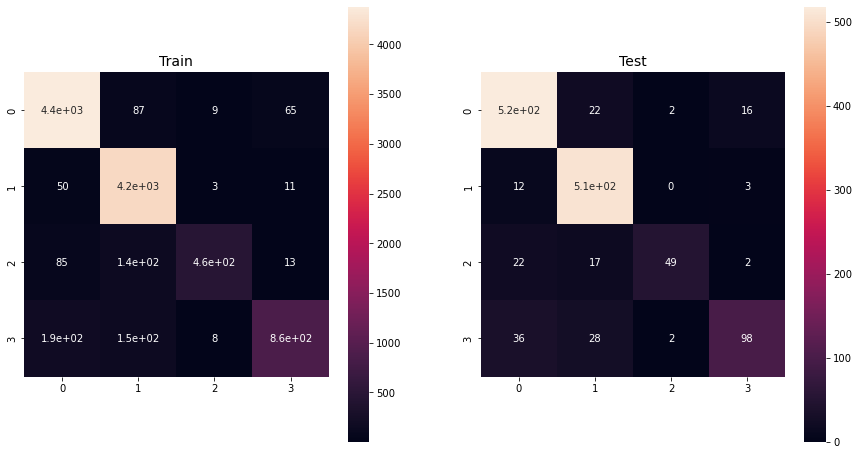

In [91]:
# 5
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


x = pd.read_csv("train.feature.txt", sep="\t")
y = pd.read_csv("train.txt", sep="\t")["CATEGORY"]
pred = model.predict(x)
train_cm = confusion_matrix(y, pred)

x = pd.read_csv("test.feature.txt", sep="\t")
y = pd.read_csv("test.txt", sep="\t")["CATEGORY"]
pred = model.predict(x)
test_cm = confusion_matrix(y, pred)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.heatmap(train_cm, square=True, annot=True)
plt.title("Train", fontsize=14)
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, square=True, annot=True)
plt.title("Test", fontsize=14)

In [104]:
# 6
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def calc_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])
    precision = np.append(precision, precision_score(y_true, y_pred, average="micro", labels=['b', 'e', 't', 'm']))
    precision = np.append(precision, precision_score(y_true, y_pred, average="macro", labels=['b', 'e', 't', 'm']))

    recall = recall_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])
    recall = np.append(recall, recall_score(y_true, y_pred, average="micro", labels=['b', 'e', 't', 'm']))
    recall = np.append(recall, recall_score(y_true, y_pred, average="macro", labels=['b', 'e', 't', 'm']))

    f1 = f1_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])
    f1 = np.append(f1, f1_score(y_true, y_pred, average="micro", labels=['b', 'e', 't', 'm']))
    f1 = np.append(f1, f1_score(y_true, y_pred, average="macro", labels=['b', 'e', 't', 'm']))

    df = pd.DataFrame(
        {"precision": precision, "recall": recall, "f1": f1},
        index=["b", "e", "t", "m", "macro-average", "micro-average"]
    )

    return df

x = pd.read_csv("train.feature.txt", sep="\t")
y = pd.read_csv("train.txt", sep="\t")["CATEGORY"]
pred = model.predict(x)
score = calc_score(y, pred)
print("Train")
print(score)

x = pd.read_csv("test.feature.txt", sep="\t")
y = pd.read_csv("test.txt", sep="\t")["CATEGORY"]
pred = model.predict(x)
score = calc_score(y, pred)
print("\nTest")
print(score)

Train
               precision    recall        f1
b               0.931277  0.964522  0.947608
e               0.917383  0.984863  0.949926
t               0.906414  0.715353  0.799629
m               0.958506  0.659058  0.781065
macro-average   0.924382  0.924382  0.924382
micro-average   0.928395  0.830949  0.869557

Test
               precision    recall        f1
b               0.880952  0.928315  0.904014
e               0.883275  0.971264  0.925182
t               0.823529  0.597561  0.692580
m               0.924528  0.544444  0.685315
macro-average   0.878561  0.878561  0.878561
micro-average   0.878071  0.760396  0.801773


In [133]:
# 7
classes = ['b', 'e', 't', 'm']
feature = pd.read_csv("train.feature.txt", sep="\t").columns
coef = model.coef_

for c in range(coef.shape[0]):
    sort_idx = np.argsort(-coef[c, :])
    high_idx, low_idx = sort_idx[:10], sort_idx[-10:]
    print(f"---------- Class: {classes[c]} ----------")
    print("上位", feature[high_idx].tolist())
    print("下位", feature[low_idx].tolist())

---------- Class: b ----------
上位 ['stocks', 'fed', 'bank', 'ecb', 'china', 'euro', 'oil', 'obamacare', 'yellen', 'ukraine']
下位 ['tv', 'star', 'aereo', 'virus', 'microsoft', 'she', 'ebola', 'and', 'video', 'her']
---------- Class: e ----------
上位 ['kardashian', 'chris', 'star', 'kim', 'miley', 'cyrus', 'movie', 'film', 'thrones', 'jay']
下位 ['billion', 'apple', 'facebook', 'study', 'says', 'gm', 'china', 'google', 'us', 'update']
---------- Class: t ----------
上位 ['ebola', 'cancer', 'study', 'drug', 'fda', 'mers', 'cases', 'cdc', 'could', 'outbreak']
下位 ['ceo', 'game', 'bank', 'climate', 'sales', 'apple', 'amazon', 'google', 'facebook', 'gm']
---------- Class: m ----------
上位 ['google', 'facebook', 'apple', 'microsoft', 'climate', 'gm', 'nasa', 'tesla', 'mobile', 'comcast']
下位 ['cancer', 'thrones', 'ecb', 'ukraine', 'her', 'york', 'american', 'drug', 'fed', 'stocks']


/Users/nozomu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:760: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1. / C, sample_weight),
/Users/nozomu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:300: RuntimeWarning: invalid value encountered in double_scalars
  loss += 0.5 * alpha * squared_norm(w)
/Users/nozomu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:352: RuntimeWarning: invalid value encountered in multiply
  grad[:, :n_features] += alpha * w
/Users/nozomu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

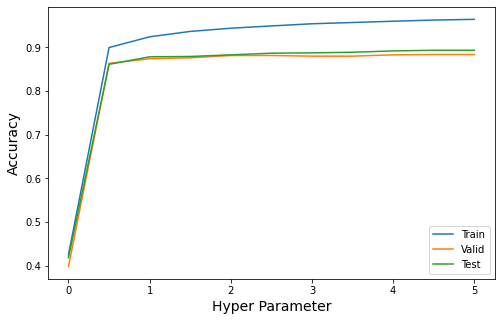

In [143]:
# 8
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

train_x = pd.read_csv("train.feature.txt", sep="\t")
train_y = pd.read_csv("train.txt", sep="\t")["CATEGORY"]
valid_x = pd.read_csv("valid.feature.txt", sep="\t")
valid_y = pd.read_csv("valid.txt", sep="\t")["CATEGORY"]
test_x = pd.read_csv("test.feature.txt", sep="\t")
test_y = pd.read_csv("test.txt", sep="\t")["CATEGORY"]

train_score, valid_score, test_score = [], [], []
params = np.linspace(0, 5, 11)
for param in params:
    model = LogisticRegression(random_state=42, max_iter=1000, C=param)
    model.fit(train_x, train_y)
    pred = model.predict(train_x)
    train_score.append(accuracy_score(train_y, pred))
    pred = model.predict(valid_x)
    valid_score.append(accuracy_score(valid_y, pred))
    pred = model.predict(test_x)
    test_score.append(accuracy_score(test_y, pred))

plt.figure(figsize=(8, 5))
plt.plot(params, train_score, label="Train")
plt.plot(params, valid_score, label="Valid")
plt.plot(params, test_score, label="Test")
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Hyper Parameter", fontsize=14)
plt.legend()

In [156]:
# 9
import optuna
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier",
        [
            "LogisticRegression",
            "SVC",
            "RandomForest"
        ]
    )

    train_x = pd.read_csv("train.feature.txt", sep="\t")
    train_y = pd.read_csv("train.txt", sep="\t")["CATEGORY"]
    valid_x = pd.read_csv("valid.feature.txt", sep="\t")
    valid_y = pd.read_csv("valid.txt", sep="\t")["CATEGORY"]
    test_x = pd.read_csv("test.feature.txt", sep="\t")
    test_y = pd.read_csv("test.txt", sep="\t")["CATEGORY"]

    if classifier_name == "LogisticRegression":
        logreg_c = trial.suggest_float(
            "logreg_c",
            1e-10, 100,
            log=True
        )
        classifier = LogisticRegression(
            C=logreg_c,
            random_state=42
        )
    elif classifier_name == "SVC":
        svc_c = trial.suggest_float(
            "logreg_c",
            1e-10, 100,
            log=True
        )
        classifier = SVC(
            C=svc_c,
            random_state=42
        )
    else:
        rf_n_estimators = trial.suggest_int(
            "rf_n_estimators",
            1, 100
        )
        rf_max_depth = trial.suggest_int(
            "rf_max_depth",
            1, 100,
        )
        classifier = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            max_depth=rf_max_depth,
            random_state=42
        )
    
    model.fit(train_x, train_y)
    pred = model.predict(valid_x)
    score = accuracy_score(valid_y, pred)

    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=3600)

print("Best trial:")
trial = study.best_trial
print("  Value: {:.3f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))